In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

In [24]:
FOLDER_PATH = "D:\\Google Drive\\Catherning Folder\\THU\\Thesis\\Recipe datasets\\"
DATASET = ["scirep-cuisines-detail","Yummly28"]
FILES = ["random_data.pkl","cluster_centroid_data.pkl","full_data.pkl"]

In [25]:
df_train=pd.read_pickle(os.path.join(FOLDER_PATH,DATASET[1],FILES[1]))
df_train=df_train.reset_index()
df_train

,level_0,index,id,cuisine,ingredients,all_ingredients,american_id
0,0,0,0,Italian,"[baby bella mushroom sliced, arborio rice, oli...",baby bella mushroom sliced;arborio rice;olive ...,NaN
1,1,1,1,Barbecue,"[pork country style rib fat trimmed, soy sauce...",pork country style rib fat trimmed;soy sauce;w...,NaN
2,2,2,2,Italian,"[garlic, extra-virgin olive oil divided, madei...",garlic;extra-virgin olive oil divided;madeira ...,NaN
3,3,3,3,French,"[garlic halved, cooking spray, peeled red pota...",garlic halved;cooking spray;peeled red potato;...,NaN
4,4,4,4,Barbecue,"[lean ground beef, worcestershire sauce, liqui...",lean ground beef;worcestershire sauce;liquid s...,NaN
...,...,...,...,...,...,...,...
16784,27618,27630,27630,Italian,"[linguine, kosher salt, olive oil, garlic chop...",linguine;kosher salt;olive oil;garlic chopped ...,NaN
16785,27621,27633,27633,Italian,"[zwiebeln, knoblauchzehen, dose dicke weisse b...",zwiebeln;knoblauchzehen;dose dicke weisse bohn...,NaN
16786,27623,27635,27635,French,"[gr. bread flour, ml. water, gr. yeast, gr. st...",gr. bread flour;ml. water;gr. yeast;gr. strong...,NaN
16787,27624,27636,27636,American,"[flour, unsweetened cocoa powder, baking soda,...",flour;unsweetened cocoa powder;baking soda;sal...,11728.0


In [26]:
cv = CountVectorizer()
X = cv.fit_transform(df_train['all_ingredients'].values)

## Processing

In [27]:
enc = LabelEncoder()
y = enc.fit_transform(df_train.cuisine)
print(enc.classes_)
enc.classes_.shape

['American' 'Asian' 'Barbecue' 'Cajun & Creole' 'Chinese' 'Cuban'
 'English_Irish' 'French' 'Greek' 'Indian' 'Italian' 'Japanese'
 'Kid-Friendly' 'Mediterranean' 'Mexican' 'Moroccan'
 'Southern & Soul Food' 'Southwestern' 'Spanish_Portuguese' 'Thai']


(20,)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 178,
 1: 391,
 2: 68,
 3: 4,
 4: 53,
 5: 6,
 6: 3,
 7: 313,
 8: 16,
 9: 292,
 10: 914,
 11: 2,
 12: 192,
 13: 14,
 14: 679,
 15: 2,
 16: 30,
 17: 120,
 18: 12,
 19: 69}

# Logistic Regression

In [29]:
parameters = {'C':[0.1,0.3,0.6,0.9,1],
              'solver' : ('newton-cg', 'liblinear')}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
logistic = LogisticRegression(class_weight="balanced",multi_class="auto",max_iter=150,warm_start=True)

clf = GridSearchCV(logistic, parameters, cv=4,scoring=scoring)
clf.fit(X_train, y_train)

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'pre

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=150, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=True),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 0.3, 0.6, 0.9, 1],
                         'solver': ('newton-cg', 'liblinear')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=0)

## Results

In [30]:
# pd.DataFrame(clf.cv_results_)
print(clf.best_estimator_)
clf.best_score_

LogisticRegression(C=0.3, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=150, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=True)


0.7737580824668472

In [31]:
clf.best_estimator_.score(X_test, y_test)

0.7680166765932103

In [32]:
def confusion_matrix_plot(y_pred,y_labels):
    plt.figure(figsize=(10, 10))

    cm = confusion_matrix(y_labels, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_normalized, interpolation='nearest')
    plt.title("confusion matrix")
    plt.colorbar(shrink=0.3)
    cuisines = df_train['cuisine'].value_counts().index
    tick_marks = np.arange(len(cuisines))
    plt.xticks(tick_marks, enc.classes_, rotation=90)
    plt.yticks(tick_marks, enc.classes_)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

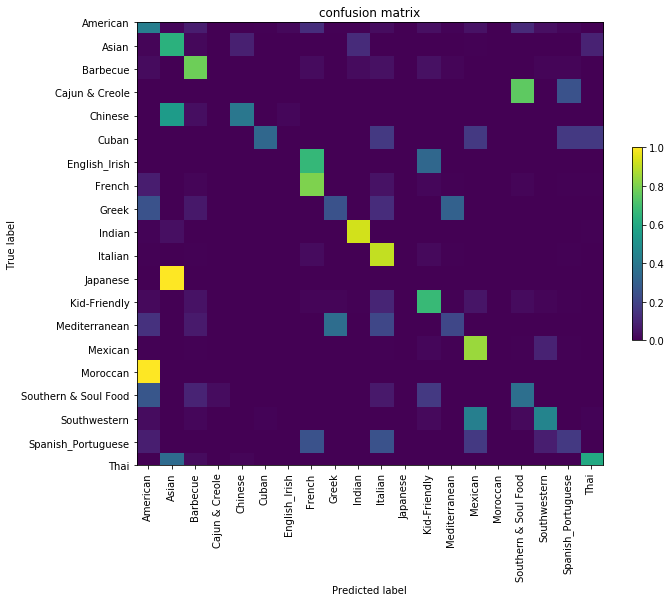

In [33]:
y_pred = clf.best_estimator_.predict(X_test)
confusion_matrix_plot(y_pred, y_test)

In [34]:
print(classification_report(y_test, y_pred, labels=[i for i in range(69)], target_names=enc.classes_))

                      precision    recall  f1-score   support

            American       0.51      0.43      0.46       178
               Asian       0.78      0.64      0.70       391
            Barbecue       0.48      0.78      0.59        68
      Cajun & Creole       0.00      0.00      0.00         4
             Chinese       0.38      0.40      0.39        53
               Cuban       0.29      0.33      0.31         6
       English_Irish       0.00      0.00      0.00         3
              French       0.80      0.81      0.80       313
               Greek       0.27      0.25      0.26        16
              Indian       0.84      0.93      0.88       292
             Italian       0.93      0.91      0.92       914
            Japanese       0.00      0.00      0.00         2
        Kid-Friendly       0.69      0.67      0.68       192
       Mediterranean       0.14      0.21      0.17        14
             Mexican       0.88      0.85      0.86       679
       

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 69, does not match size of target_names, 20
  .format(len(labels), len(target_names))
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Random Forest

much slower and a bit worse

In [35]:
parameters = {'max_depth':(None,3,5,8)}
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
rf = RandomForestClassifier(n_estimators=200, random_state=123,class_weight="balanced")

clf = GridSearchCV(rf, parameters, cv=4,scoring=scoring)
clf.fit(X_train, y_train)

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'pre

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False, random_state=123,
                                              verbose=0, warm_start=False),
             i

In [36]:
print(clf.best_estimator_)
clf.best_score_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=None, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


0.7115365955530623

In [37]:
clf.best_estimator_.score(X_test, y_test)

0.7605717689100655

## Results

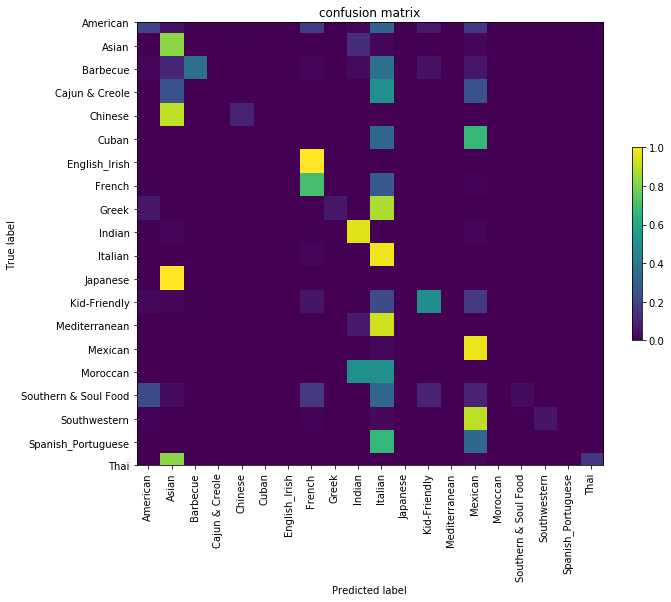

In [38]:
y_pred = clf.predict(X_test)
confusion_matrix_plot(y_pred, y_test)

In [39]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, labels=[i for i in range(69)], target_names=enc.classes_))

                      precision    recall  f1-score   support

            American       0.62      0.20      0.31       178
               Asian       0.71      0.83      0.76       391
            Barbecue       0.89      0.37      0.52        68
      Cajun & Creole       0.00      0.00      0.00         4
             Chinese       0.71      0.09      0.17        53
               Cuban       0.00      0.00      0.00         6
       English_Irish       0.00      0.00      0.00         3
              French       0.75      0.71      0.73       313
               Greek       1.00      0.06      0.12        16
              Indian       0.82      0.95      0.88       292
             Italian       0.76      0.98      0.85       914
            Japanese       0.00      0.00      0.00         2
        Kid-Friendly       0.81      0.49      0.61       192
       Mediterranean       0.00      0.00      0.00        14
             Mexican       0.77      0.97      0.86       679
       

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 69, does not match size of target_names, 20
  .format(len(labels), len(target_names))
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# SVM

In [40]:
parameters = {'loss':('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron')
              }
# sorted(sklearn.metrics.SCORERS.keys())
scoring = 'f1_weighted'
sgd = SGDClassifier(class_weight="balanced",early_stopping=True,warm_start=True)

clf = GridSearchCV(sgd, parameters, cv=4,scoring=scoring)
clf.fit(X_train, y_train)

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight='balanced',
                                     early_stopping=True, epsilon=0.1, eta0=0.0,
                                     fit_intercept=True, l1_ratio=0.15,
                                     learning_rate='optimal', loss='hinge',
                                     max_iter=1000, n_iter_no_change=5,
                                     n_jobs=None, penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=True),
             iid='warn', n_jobs=None,
             param_grid={'loss': ('hinge', 'log', 'modified_huber',
                                  'squared_hinge', 'perceptron')},
             pre_dispatch='2*n_jobs', refit=True, return_tra

In [41]:
print(clf.best_estimator_)
clf.best_score_

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=True)


0.7136842143219347

In [42]:
clf.best_estimator_.score(X_test, y_test)

0.7129243597379392

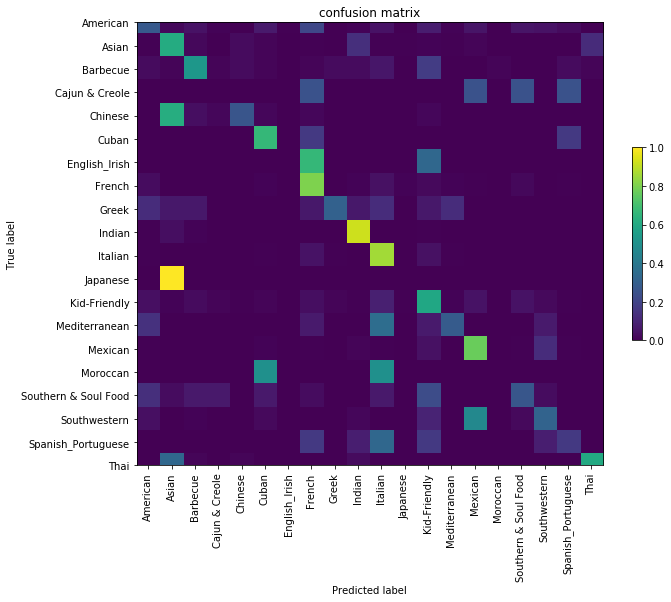

In [43]:
y_pred = clf.predict(X_test)
confusion_matrix_plot(y_pred, y_test)

In [44]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, labels=[i for i in range(69)], target_names=enc.classes_))

                      precision    recall  f1-score   support

            American       0.51      0.28      0.36       178
               Asian       0.75      0.62      0.68       391
            Barbecue       0.49      0.53      0.51        68
      Cajun & Creole       0.00      0.00      0.00         4
             Chinese       0.47      0.26      0.34        53
               Cuban       0.08      0.67      0.14         6
       English_Irish       0.00      0.00      0.00         3
              French       0.70      0.81      0.75       313
               Greek       0.33      0.31      0.32        16
              Indian       0.78      0.92      0.85       292
             Italian       0.92      0.86      0.89       914
            Japanese       0.00      0.00      0.00         2
        Kid-Friendly       0.46      0.59      0.52       192
       Mediterranean       0.17      0.29      0.22        14
             Mexican       0.86      0.77      0.81       679
       

D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 69, does not match size of target_names, 20
  .format(len(labels), len(target_names))
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Applications\Anaconda3\envs\pandas_analysis\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
